In [1]:
library(tidyverse)
library(cowplot)
library(martini)
library(blur)

gene2snp <- read_tsv("../../data/genesis/gene2snp.hg19", col_types = "cc")

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 2.2.1     ✔ purrr   0.2.4
✔ tibble  1.4.1     ✔ dplyr   0.7.4
✔ tidyr   0.7.2     ✔ stringr 1.2.0
✔ readr   1.1.1     ✔ forcats 0.2.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()  masks stats::filter()
✖ purrr::flatten() masks jsonlite::flatten()
✖ dplyr::lag()     masks stats::lag()

Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave



# GS network

In [2]:
gs <- read_tsv("cones.evo.chi2.consistency.additive.gs.tsv", 
               col_types = "iciiccdli") %>%
      rename(module = cluster)
sum(gs$selected)

[1] 1248

Warning message:
“Removed 25 rows containing non-finite values (stat_binhex).”

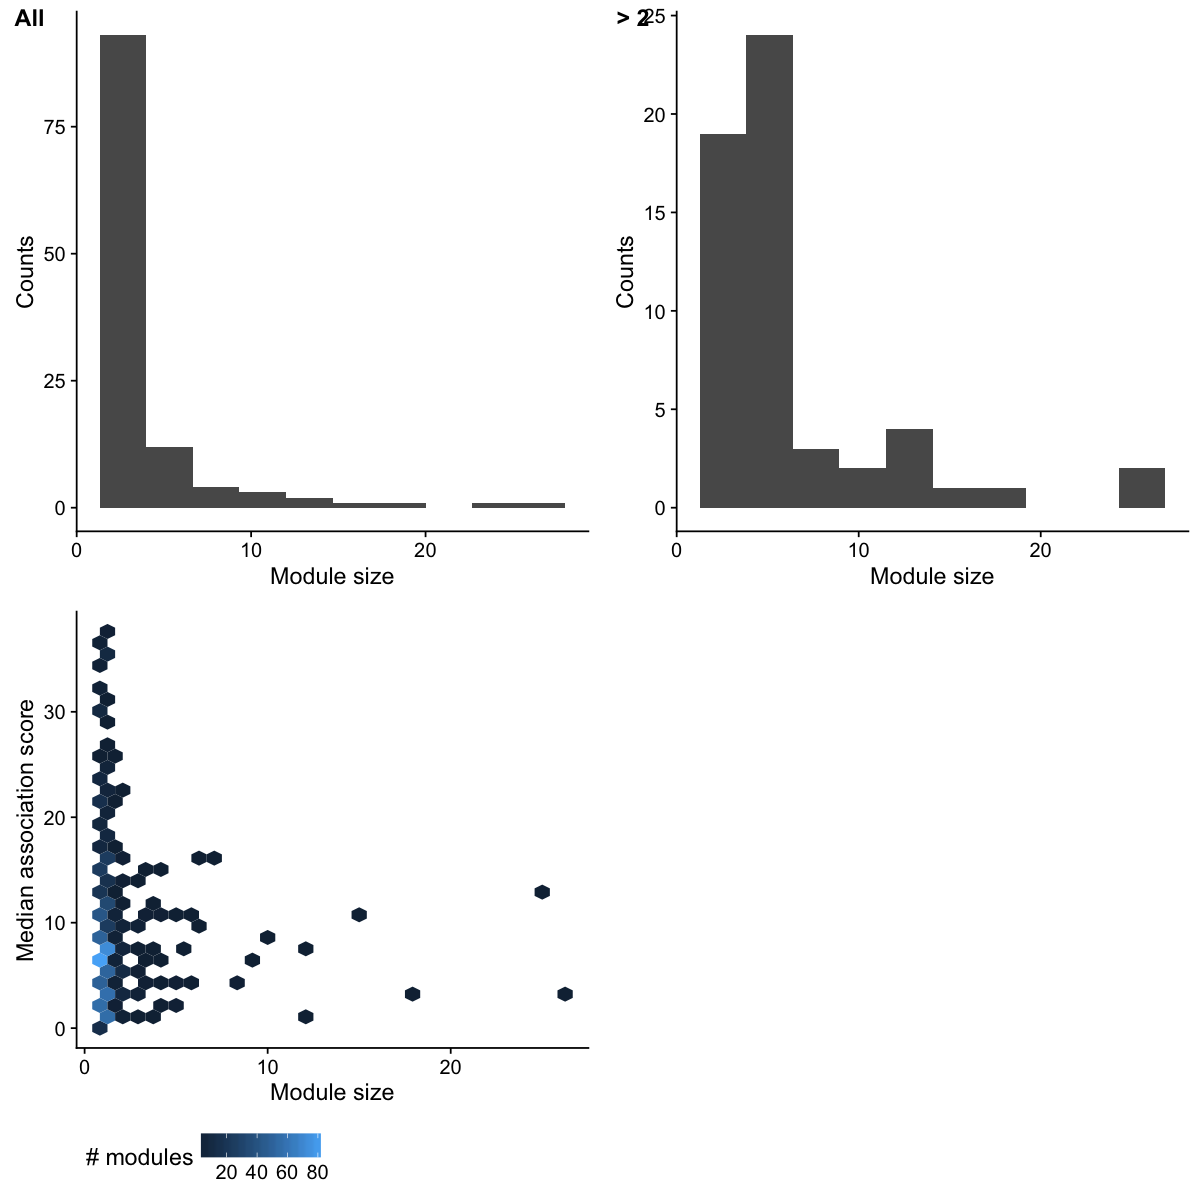

In [3]:
peekClusters <- function(cones) {
    all <- module_size(cones)
    gt2 <- cones %>%
        group_by(module) %>%
        filter(n() > 2) %>%
        module_size
    sizeVSc <- module_size_association(cones)

    options(repr.plot.width=10, repr.plot.height=10)
    plot_grid(all, gt2, sizeVSc, labels=c("All","> 2"))
}

peekClusters(gs)

In [4]:
head(gs)

chr,snp,cm,pos,allele.1,allele.2,c,selected,module
23,rs1221063,0,62542316,C,T,NaN,FALSE,NA
23,rs4543711,0,52846508,A,G,3.334516320,FALSE,NA
23,rs2806844,0,52860079,G,A,4.006483114,FALSE,NA
23,rs5991840,0,52951462,G,A,1.073690534,FALSE,NA
23,rs5991839,0,52951735,C,T,0.007915999,FALSE,NA
23,rs5951164,0,53004364,T,C,3.549682649,FALSE,NA


Most of the clusters have small sizes (1,2 SNPs). However, it seems that small clusters have a similar association scores as bigger clusters, so I am inclined to think that bigger clusters are not picked despite being having lower association scores, but because they happen to connect high-score SNPs.

In [5]:
head(blur:::compute_mod_size(gs), n = 20)

module,chr,size,C
586,8,26,2.822394
506,8,25,12.597872
280,3,18,3.684915
394,5,15,10.745120
370,5,14,NA
392,5,14,NA
50,3,12,7.479093
527,8,12,1.232985
43,3,10,8.453581
52,3,9,6.400978


It seems that the biggest clusters come from only 3 chromosomic regions in chromosomes 3, 5 and 8.

[1] TRUE

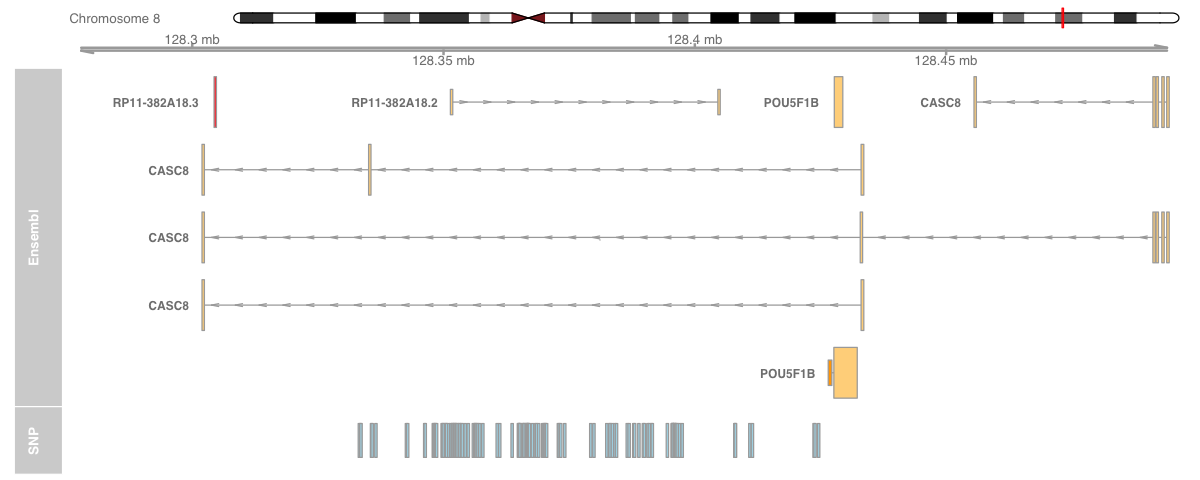

In [6]:
options(repr.plot.width=10, repr.plot.height=4)
k <- blur:::compute_mod_size(gs) %>% filter(chr == 8) %>% .$module %>% head(n = 20)
plot_snp_module(gs, k)

In chromosome 8 we find gene CASC8, which had appreared in previous analyses.

[1] TRUE

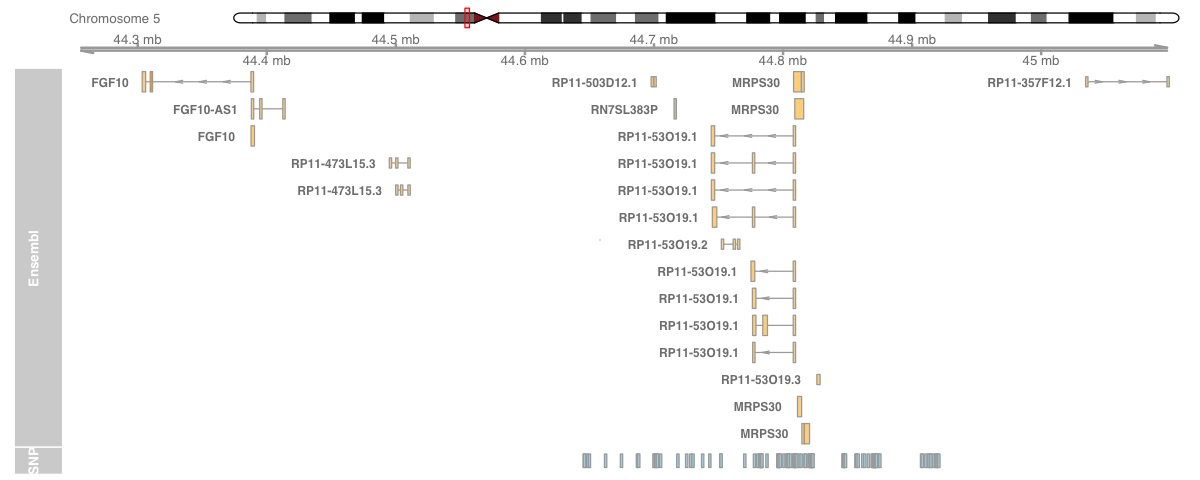

In [7]:
options(repr.plot.width=10, repr.plot.height=4)
k <- blur:::compute_mod_size(gs) %>% filter(chr == 5) %>% .$module %>% head(n = 20)
plot_snp_module(gs, k)

In this region we find two compelling genes: MRPS30, the S30 subunit of the mitochondrial ribosome and potentially involved in energetic metabolism; and, more interestingly, RP11-53O19.1, also known as Breast Cancer-Associated Transcript 54, a ncRNA.

[1] TRUE

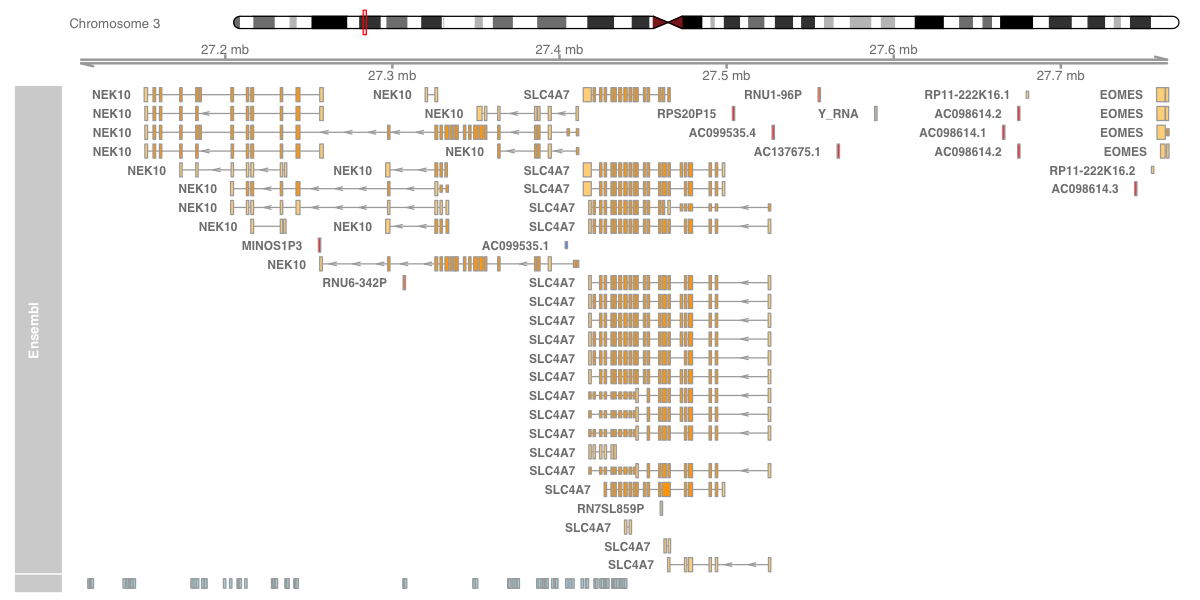

In [8]:
options(repr.plot.width=10, repr.plot.height=5)
k <- blur:::compute_mod_size(gs) %>% filter(chr == 3) %>% .$module %>% head(n = 20)
plot_snp_module(gs, k)

Here we retrieve our old-friend NEK10, a protein kinase involved in cell-cycle controlwhich was already linked to BRCA susceptibility.

## Genes affected

In [9]:
gs %>%
    filter(selected) %>%
    merge(gene2snp, by.x = "snp", by.y = "SNP") %>%
    group_by(GENE) %>%
    summarise(chr = unique(chr),
              start = min(pos),
              end = max(pos),
              SNPs = n(),
              Clusters = unique(module) %>% length,
              avgClusterSize = table(module) %>% mean) %>%
    arrange(-SNPs)

GENE,chr,start,end,SNPs,Clusters,avgClusterSize
CASC8,8,128309591,128428061,272,174,1.563218
CASC21,8,128309591,128403887,214,121,1.768595
NEK10,3,27257943,27410561,191,160,1.193750
SLC4A7,3,27416013,27492187,98,59,1.661017
FGFR2,10,123296158,123357561,63,56,1.125000
CASC16,16,52586341,52639236,54,45,1.200000
TOX3,16,52525285,52580247,47,45,1.044444
SLIT1,10,98838694,98896779,31,25,1.240000
LOC100506674,5,44751744,44808356,30,9,3.333333
CCAT2,8,128413087,128414371,7,7,1.000000


When we don't focus on clusters, but try to see signal provided by any selected SNPs we give voice to these SNPs with an association strongly associated enough to be selected without a cluster. Like this, we recover our old friend FGFR2, a tumor suppressor gene that is amplified and overexpressed in breast cancer.

[1] TRUE

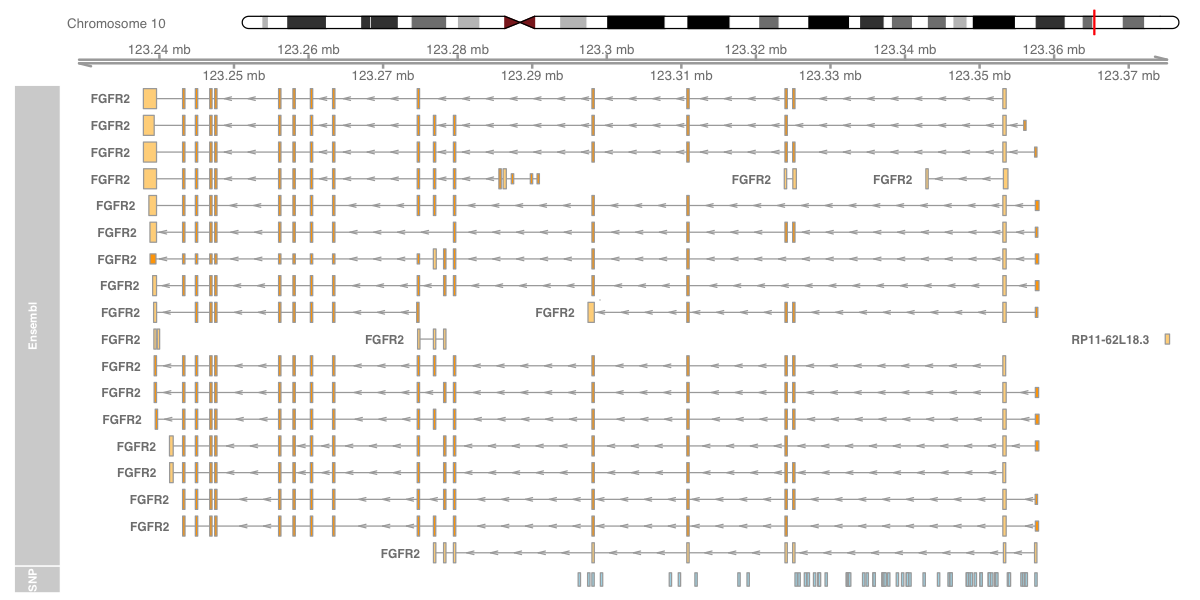

In [10]:
options(repr.plot.width=10, repr.plot.height=5)
# FGFR2 SNPs
k <- gs %>% filter(selected & chr == 10 & pos > 123296158 & pos < 123357561) %>% .$module
plot_snp_module(gs, k)

TOX3, related with ER+ BRCA, and CASC16, really close in the genome also pop up in the analysis.

[1] TRUE

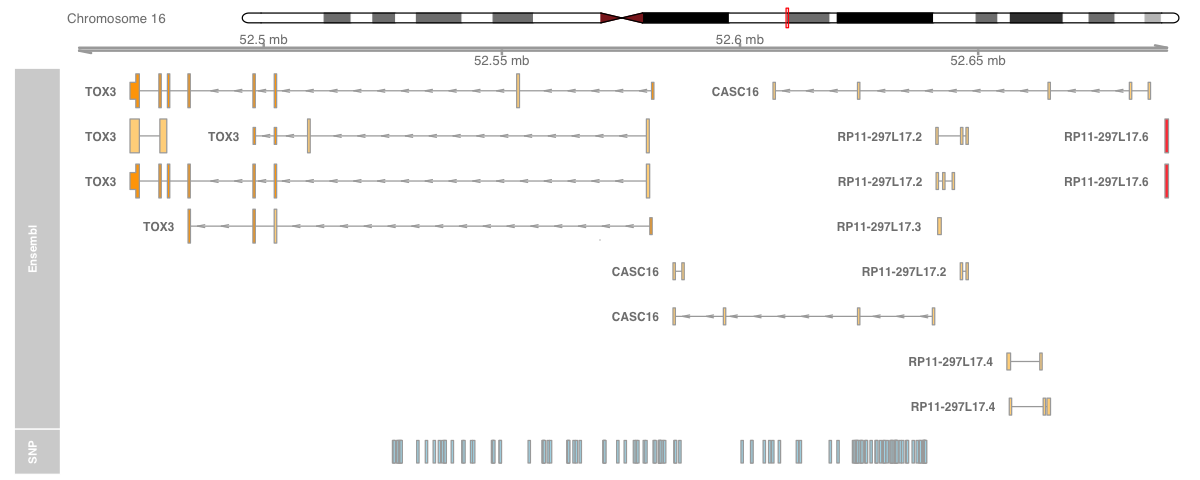

In [11]:
options(repr.plot.width=10, repr.plot.height=4)
# TOX3 SNPs
k <- gs %>% filter(selected & chr == 16 & pos > 52525285 & pos < 52639236) %>% .$module
plot_snp_module(gs, k)

# GM network

In [12]:
gm <- read_tsv("cones.evo.chi2.consistency.additive.gm.tsv", 
               col_types = "iciiccdli") %>%
      rename(module = cluster)
sum(gm$selected)

[1] 1091

Warning message:
"Removed 25 rows containing non-finite values (stat_binhex)."

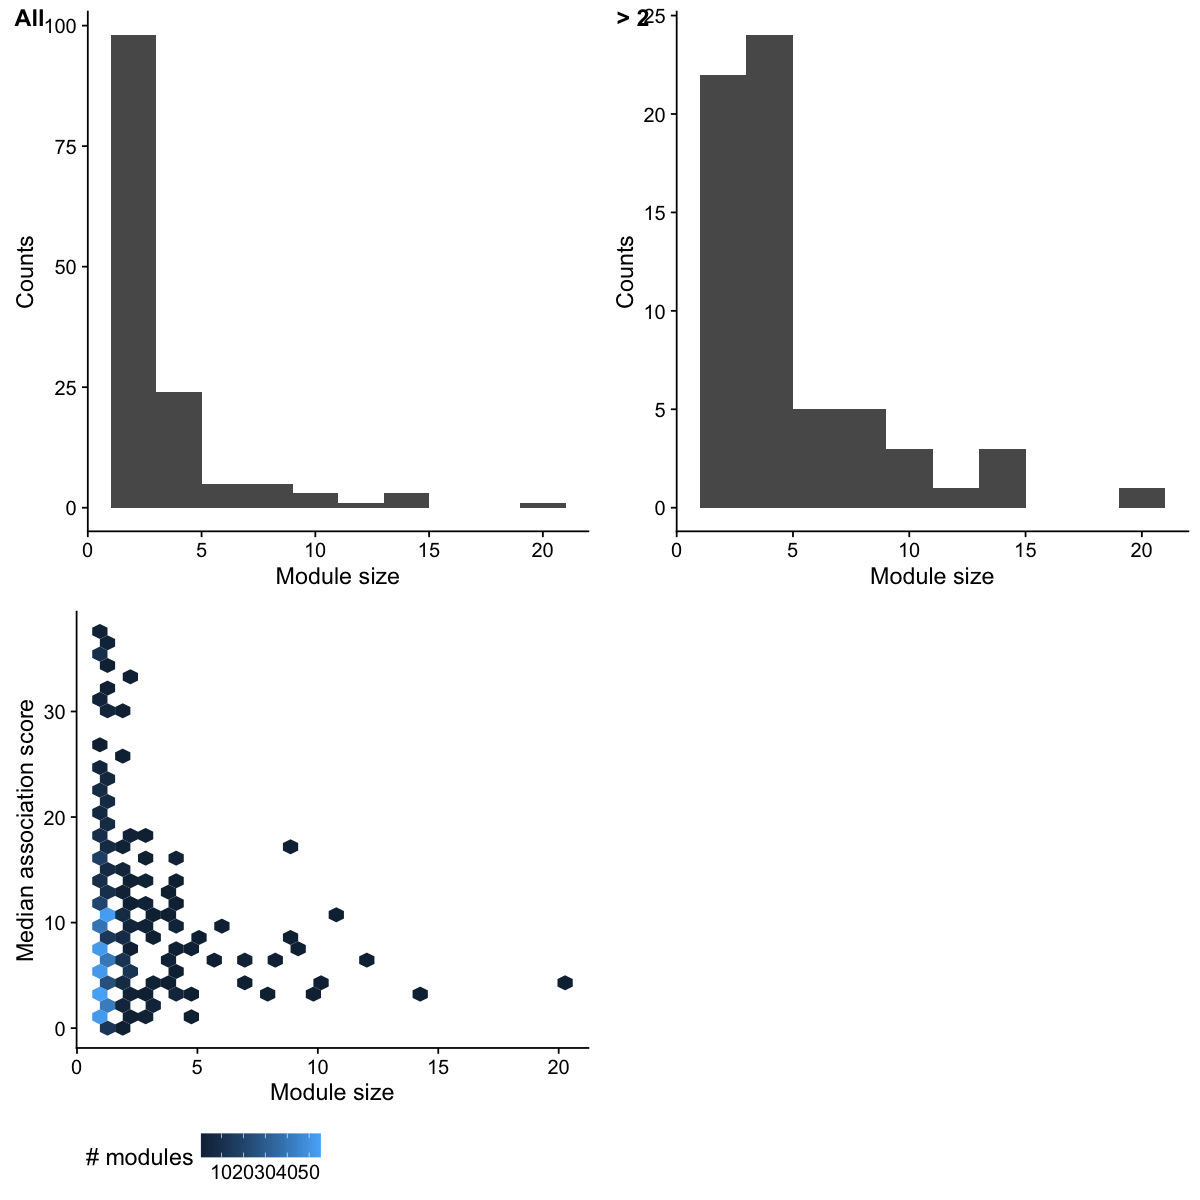

In [13]:
options(repr.plot.width=10, repr.plot.height=10)
peekClusters(gm)

In [14]:
head(blur:::compute_mod_size(gm), n = 20)

module,chr,size,C
399,3,20,3.905365
313,3,15,NA
287,3,14,NA
418,3,14,3.519701
39,3,12,7.086028
461,5,11,10.628520
41,3,10,3.170767
462,5,10,4.163540
296,3,9,8.135196
312,3,9,7.963262


Only 2 chromosomic regions here, in chromosomes 3 and 5, around the regions we already described.

[1] TRUE

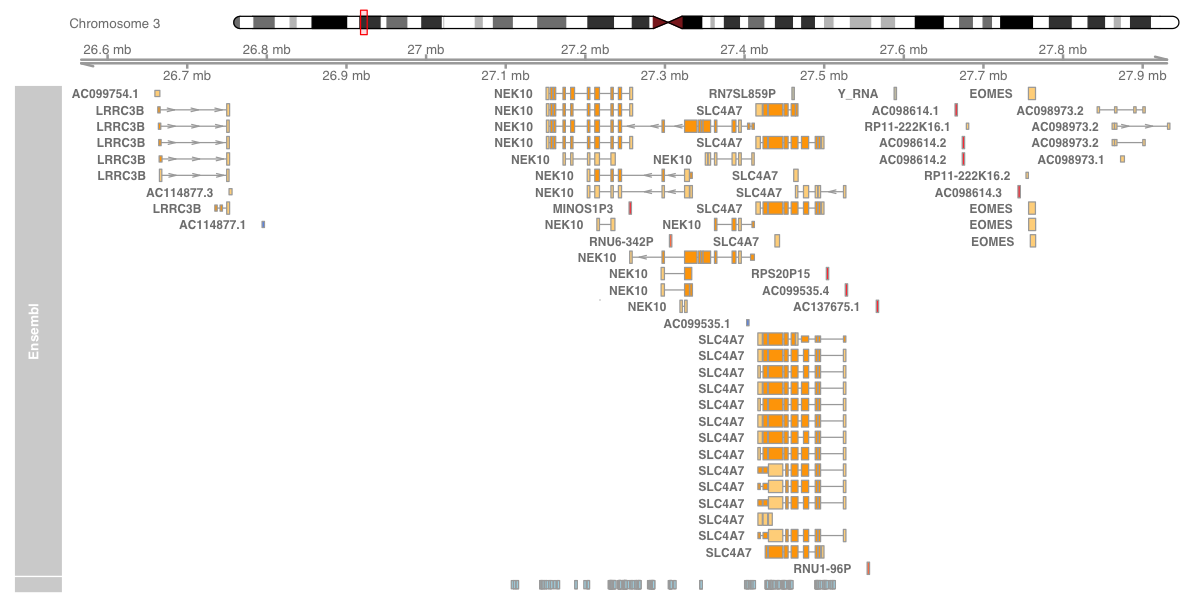

In [15]:
options(repr.plot.width=10, repr.plot.height=5)
k <- blur:::compute_mod_size(gm) %>% filter(chr == 3) %>% .$module %>% head(n = 20)
plot_snp_module(gm, k)

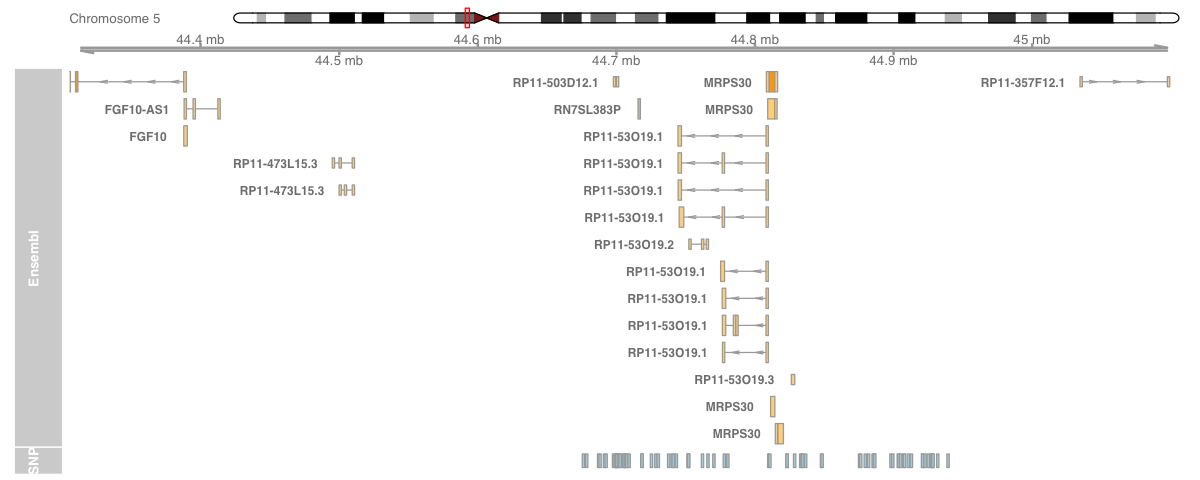

[1] TRUE

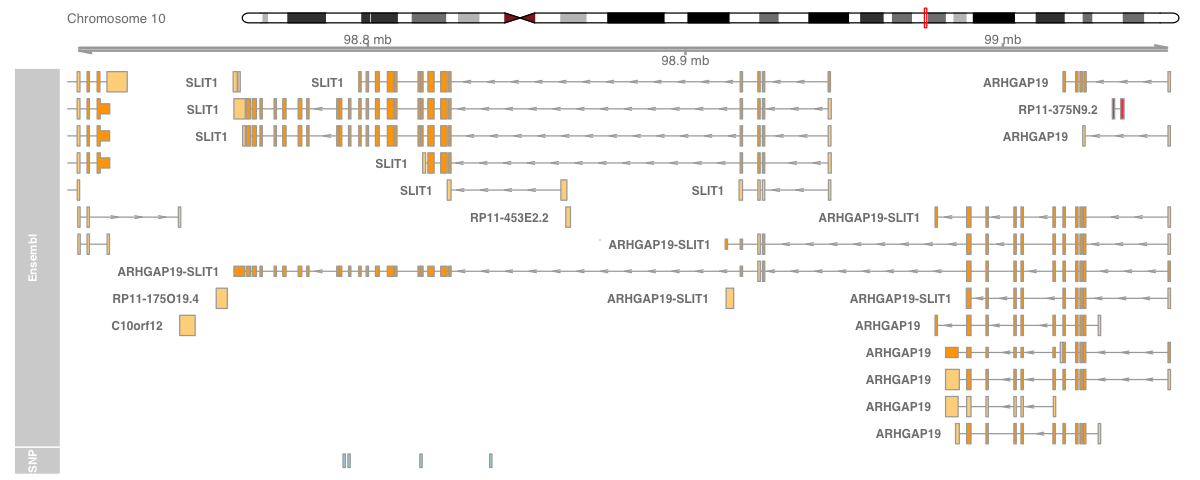

In [16]:
options(repr.plot.width=10, repr.plot.height=4)
k <- blur:::compute_mod_size(gm) %>% filter(chr == 5) %>% .$module %>% head(n = 20)
plot_snp_module(gm, k)

## Genes affected

In [17]:
gm %>%
    filter(selected) %>%
    merge(gene2snp, by.x = "snp", by.y = "SNP") %>%
    group_by(GENE) %>%
    summarise(chr = unique(chr),
              start = min(pos),
              end = max(pos),
              SNPs = n(),
              Clusters = unique(module) %>% length,
              avgClusterSize = table(module) %>% mean) %>%
    arrange(-SNPs)

GENE,chr,start,end,SNPs,Clusters,avgClusterSize
NEK10,3,27257943,27410561,191,131,1.458015
SLC4A7,3,27416013,27523275,132,59,2.237288
FGFR2,10,123238052,123357561,108,91,1.186813
CASC16,16,52586341,52639236,54,46,1.173913
TOX3,16,52521628,52580247,48,34,1.411765
SLIT1,10,98792520,98937895,35,19,1.842105
LOC100506674,5,44751744,44808356,30,22,1.363636
ARHGAP19-SLIT1,10,98937895,99023546,7,6,1.166667
MRPS30,5,44809162,44814004,6,5,1.200000
ARHGAP19,10,99009969,99023546,3,3,1.000000


# GI network

In [18]:
gi <- read_tsv("cones.evo.chi2.consistency.additive.gi.tsv", 
               col_types = "iciiccdld") %>%
      rename(module = cluster)
sum(gi$selected)

[1] 2227

Warning message:
"Removed 53 rows containing non-finite values (stat_binhex)."

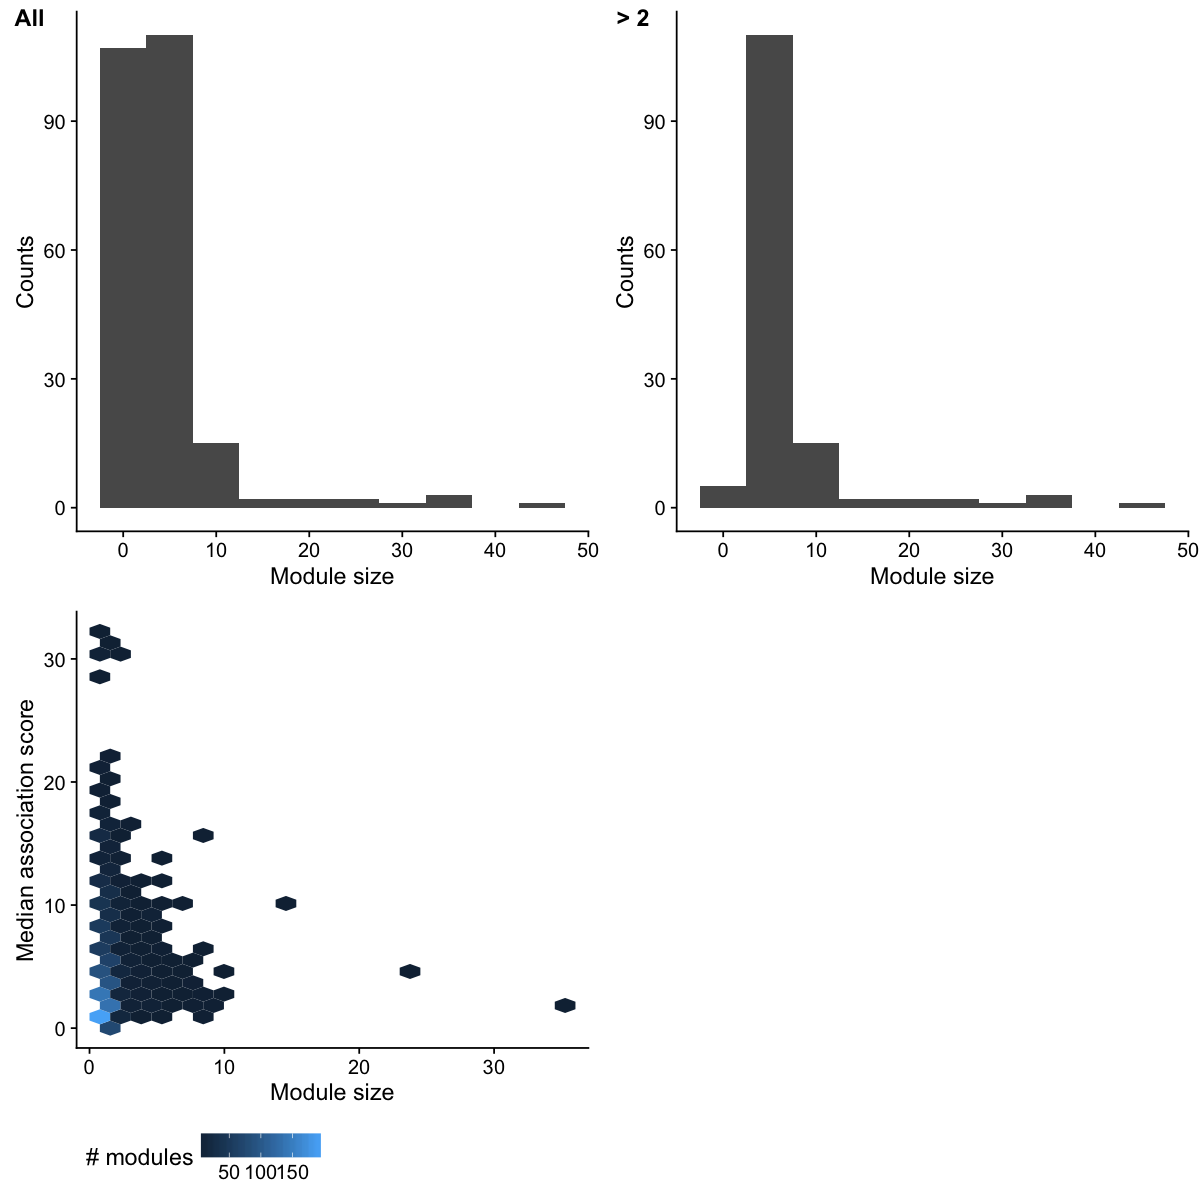

In [19]:
options(repr.plot.width=10, repr.plot.height=10)
peekClusters(gi)

In [20]:
head(blur:::compute_mod_size(gi), n = 20)

module,chr,size,C
1,5,47,NA
1,3,35,NA
1,8,35,2.037973
1,2,33,NA
73,5,30,NA
1,10,24,4.366318
1,16,23,NA
1,7,22,NA
204,3,19,NA
764,5,15,NA


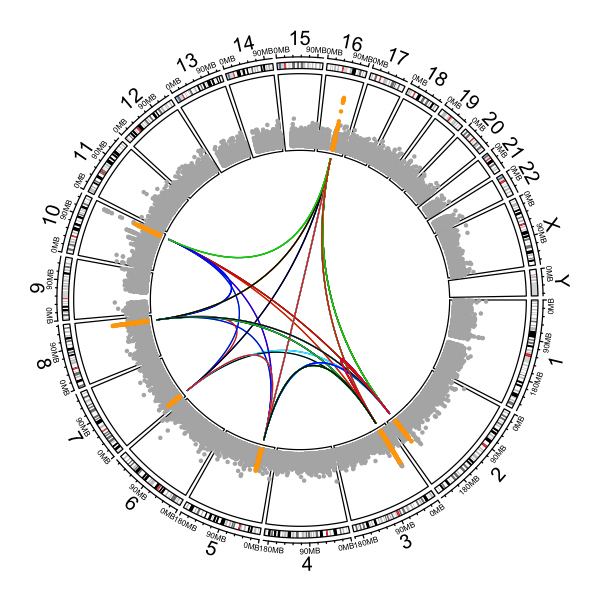

In [21]:
options(repr.plot.width=5, repr.plot.height=5)
plot_ideogram(gi)

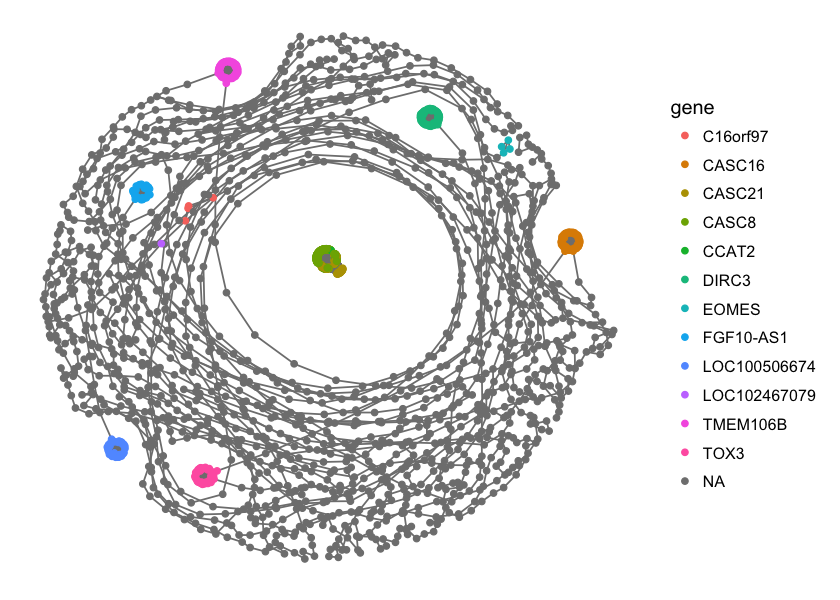

In [22]:
load("../../data/genesis/gi.net")
load("../../data/genesis/genesis.RData")

options(repr.plot.width=7, repr.plot.height=5)
suppressMessages(plot_subnetwork(genesis, net, gi$snp[gi$selected]))

## Genes affected

In [23]:
gi %>%
    filter(selected) %>%
    merge(gene2snp, by.x = "snp", by.y = "SNP") %>%
    group_by(GENE) %>%
    summarise(chr = unique(chr),
              start = min(pos),
              end = max(pos),
              SNPs = n(),
              Clusters = unique(module) %>% length,
              avgClusterSize = table(module) %>% mean) %>%
    arrange(-SNPs)

GENE,chr,start,end,SNPs,Clusters,avgClusterSize
CASC8,8,128302639,128493983,416,307,1.355049
CASC21,8,128260183,128403887,278,179,1.553073
DIRC3,2,218150948,218606227,66,37,1.783784
TMEM106B,7,12251488,12275818,63,43,1.465116
CASC16,16,52586341,52639236,54,42,1.285714
TOX3,16,52521628,52580247,48,33,1.454545
LOC100506674,5,44751744,44808356,30,24,1.250000
FGF10-AS1,5,44391161,44413040,25,10,2.500000
CCAT2,8,128413087,128414371,7,6,1.166667
C16orf97,16,52067619,52104424,4,2,2.000000


One interesting gene that didn't pop up in previous experiments is DIRC3, associated to renal and thyroid carcinomas; the other is CCAT2, related to prostate cancer susceptibility

[1] TRUE

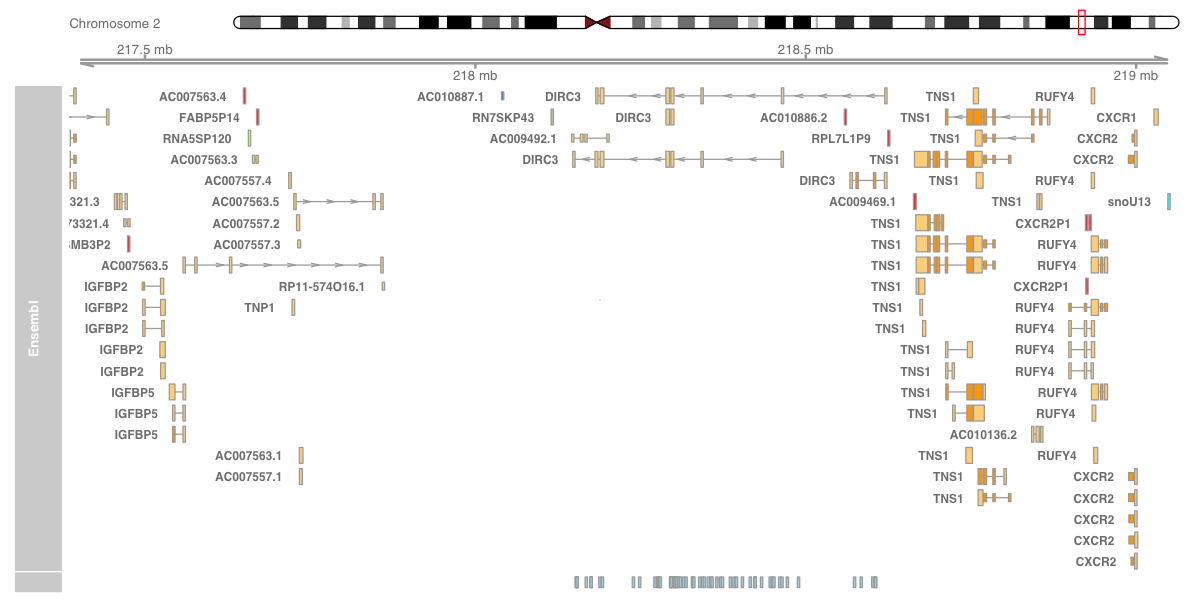

In [24]:
options(repr.plot.width=10, repr.plot.height=5)
DIRC3 <- filter(gi, selected & chr == 2 & pos > 218150948 & pos < 218606227)
plot_snp_module(DIRC3, DIRC3$module)

[1] TRUE

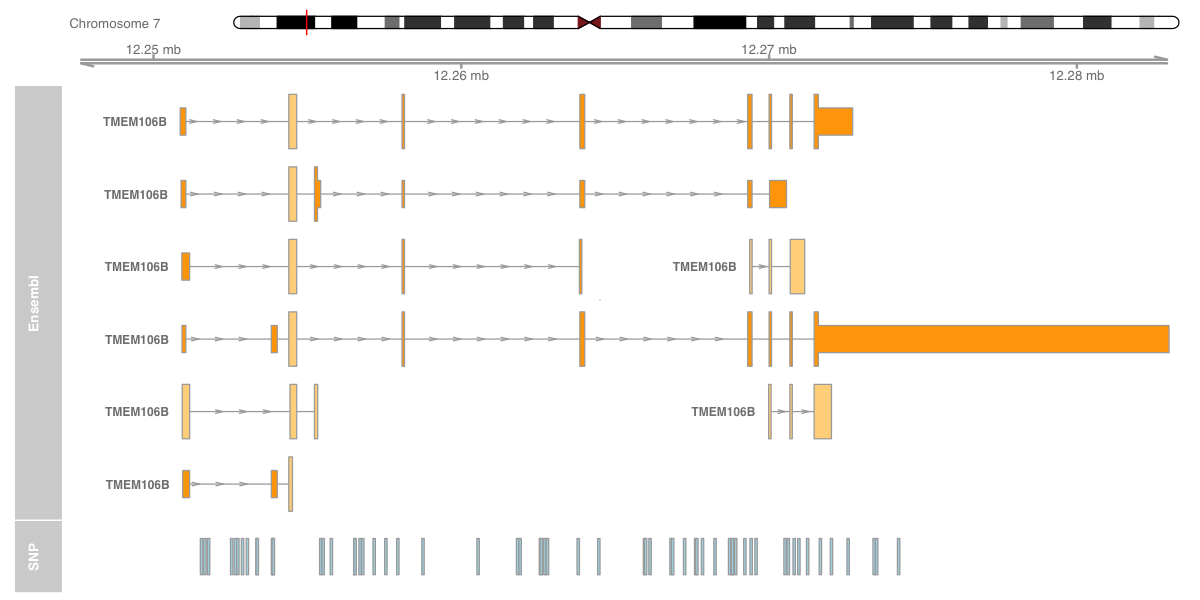

In [25]:
options(repr.plot.width=10, repr.plot.height=5)
TMEM106B <- filter(gi, selected & chr == 7 & pos > 12251488 & pos < 12275818)
plot_snp_module(TMEM106B, TMEM106B$module)

[1] TRUE

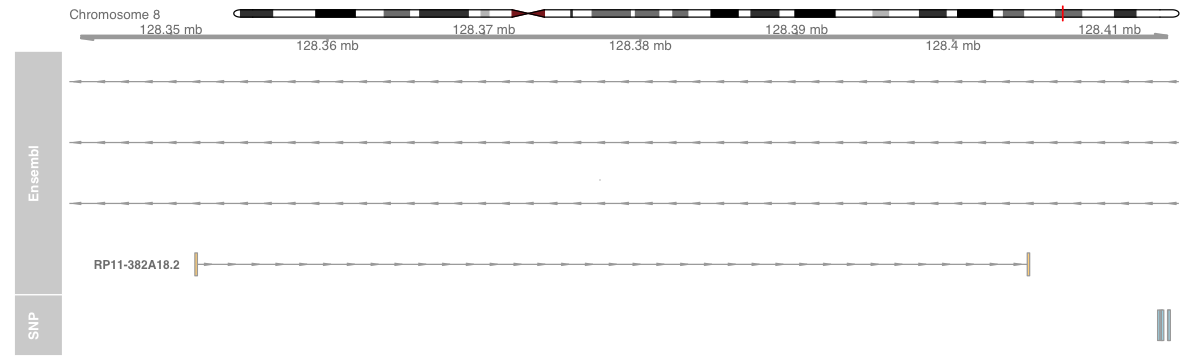

In [26]:
options(repr.plot.width=10, repr.plot.height=3)
CCAT2 <- filter(gi, selected & chr == 8 & pos > 128413087 & pos < 128414371)
plot_snp_module(CCAT2, CCAT2$module)

# GI2

GI2 refers to a network that is GI - GM + GS, or a network that contains the structural and the PPI information, but not the gene anotation. The idea behind this network is trying to enforce the impact of PPI beyond what GI network does.

In [27]:
gi2 <- read_tsv("cones.evo.chi2.consistency.additive.gi2.8484771.tsv", 
                col_types = "ciiiccdld")
sum(gi2$selected)

[1] 337

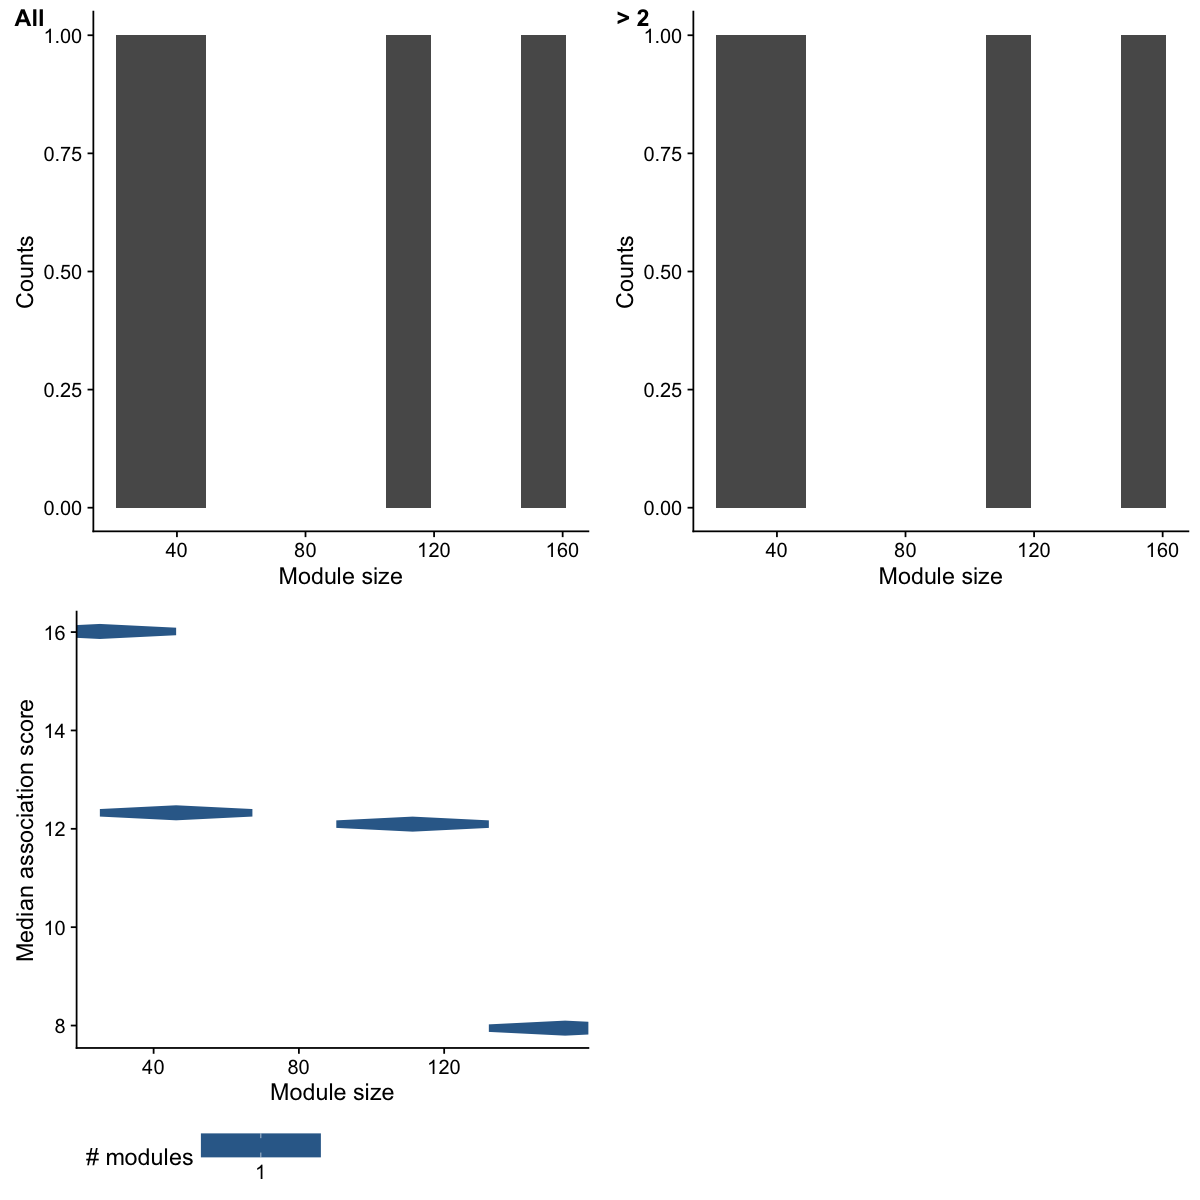

In [28]:
options(repr.plot.width=10, repr.plot.height=10)
peekClusters(gi2)

We find a few big clusters, which is encouraging.

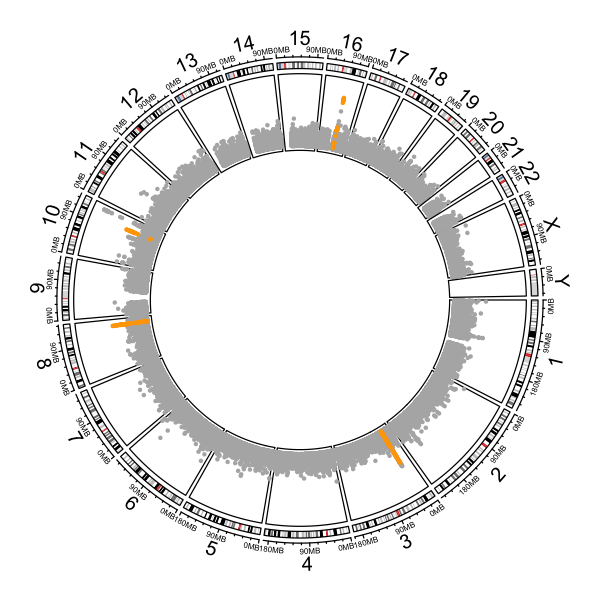

In [29]:
options(repr.plot.width=5, repr.plot.height=5)
plot_ideogram(gi2)

Nonetheless, the SNPs are not connected to each other, so we are still not enforcing the PPI aspect of the network.

# Consistency

How consistent are the selected SNPs in the different networks?

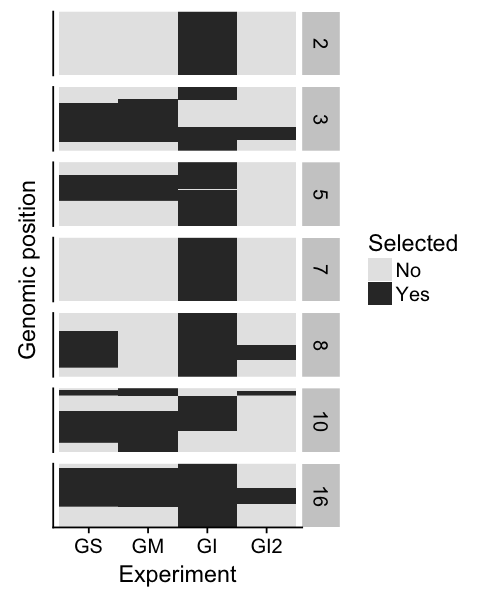

In [30]:
options(repr.plot.width=4, repr.plot.height=5)
consistency(GS = gs, GM = gm, GI = gi, GI2 = gi2)

GI network selects twice as many SNPs as the GM and the GS networks. As we see, most of the SNPs selected in the GS are selected in GS, and most of the ones selected in GM (+ many more) are selected in GI. Interestingly, as we can see from the circos above, GI network provides a way of connecting the previously isolated chromosomic regions in 3, 5 and 8 (and some potentially interesting regions in chromosomes 10 and 16).

# Comparison to traditional GWAS

Warning message:
"Removed 63 rows containing missing values (geom_point)."

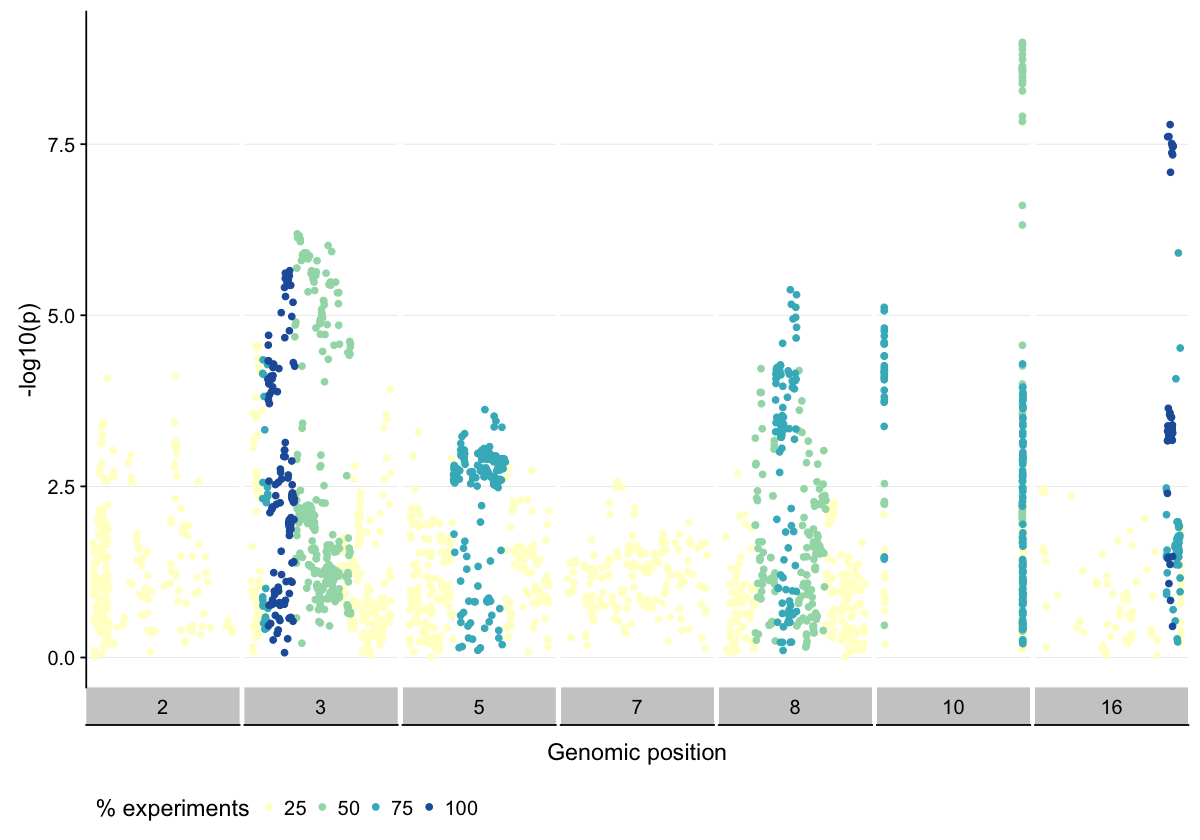

In [31]:
options(repr.plot.width=10, repr.plot.height=7)

C <- blur:::join_experiments(GS = gs, GM = gm, GI = gi, GI2 = gi2) %>%
    mutate(C = rowMeans(.[grep("C_", names(.))], na.rm = T),
           consistency = factor(100 * consistency, levels = c("0","25","50","75","100")))

arrange(C, consistency) %>%
    mutate(p = pchisq(C, df = 1, lower.tail = F)) %>%
    ggplot(aes(x = pos, y = -log10(p), color = consistency)) +
        geom_point() +
        background_grid(major = "y", minor = "none") +
        theme(axis.text.x = element_blank(),
              axis.ticks.x = element_blank(),
              legend.position = "bottom",
              panel.spacing.x = unit(0.2, "lines")) +
        labs(x = "Genomic position", y = "-log10(p)", color = "% experiments") +
        scale_color_manual(values = c("0"="gray80", "25"="#ffffcc", 
                                      "50"="#a1dab4", "75"="#41b6c4", 
                                      "100"="#225ea8")) +
        facet_grid(. ~ chr, scales = "free_x", switch = "x")

The SNPs we are selecting are not exclusively among the ones we would naturally select in a classical GWAS setting, although in general they display, at least, a moderate association.

# Validation: BCAC

We want to put SConES results in the context of another dataset, to see what the SNPs look like. We selected for that the European cohort of the BCAC ([download](http://bcac.ccge.medschl.cam.ac.uk/bcacdata/icogs/)). Note that (low-powered) GWAS have issues with replication, so low p-values in one experiment doesn't imply low p-values in another one.

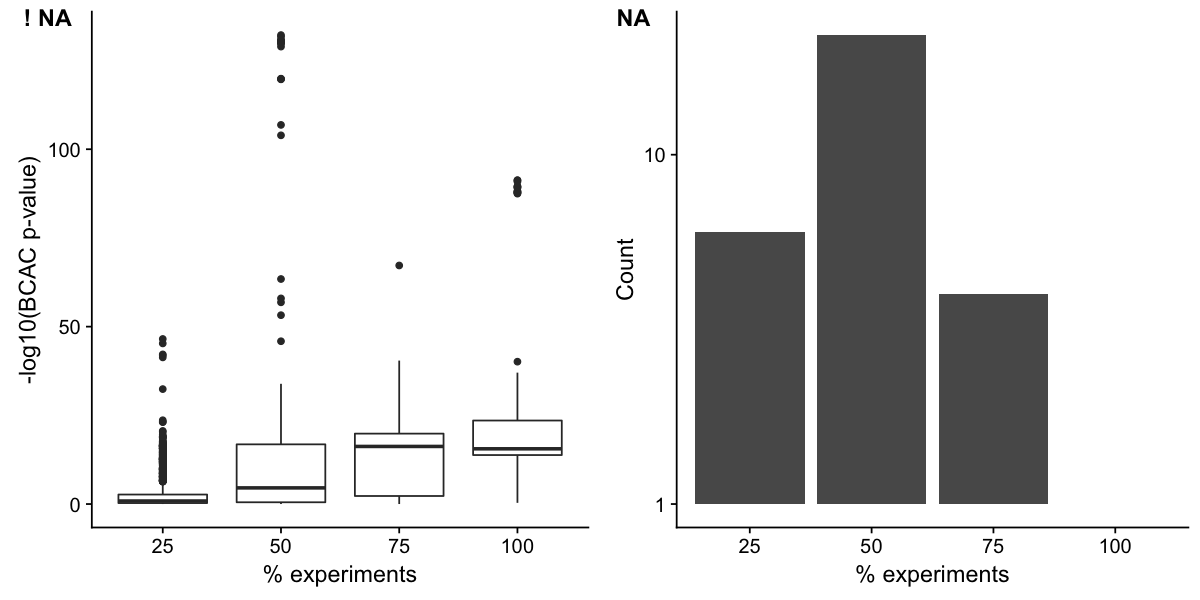

In [32]:
bcac <- read_tsv("../../data/bcac/icogs_bcac_public_results_euro.lite.txt", col_types = "cd") %>%
    rename(p_bcac = bcac_icogs1_risk_P1df) %>%
    merge(C, by.x = "phase3_1kg_id", by.y = "snp", all.y = T)

bp <- bcac %>%
    filter(!is.na(p_bcac)) %>%
    ggplot(aes(x = consistency, y = -log10(p_bcac))) +
        geom_boxplot() +
        labs(x = "% experiments", y = "-log10(BCAC p-value)")

h <- filter(bcac, is.na(p_bcac)) %>%
    ggplot(aes(x = consistency)) +
        geom_bar() +
        scale_y_log10() +
        labs(x = "% experiments", y = "Count")

options(repr.plot.width=10, repr.plot.height=5)
plot_grid(bp, h, labels=c("! NA","NA"))

It looks like we are selecting SNPs with very low p-values in the BCAC dataset too. This reinforces the This can be read in two positive ways:

- These SNPs are also moderately associated in GENESIS too, not enough to get a good, low-univariate p-value, but enough for SConES to pick up.
- SNPs with low p-values are connected in the underlying network, that's why SConES is picking them up, reinforcing our hypothesis.

Warning message:
"Removed 33 rows containing missing values (geom_point)."

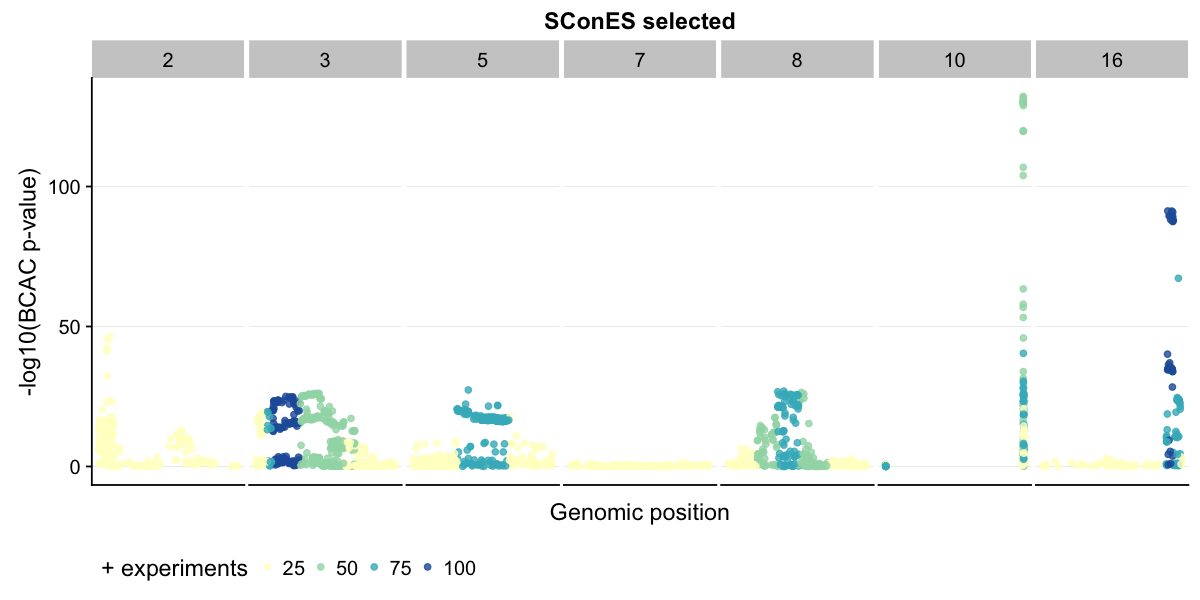

In [33]:
filter(bcac, consistency != "0") %>%
    ggplot(aes(x = pos, y = -log10(p_bcac), color = consistency)) +
        geom_point(alpha = 0.8) +
        background_grid(major = "y", minor = "none") +
        theme(axis.text.x = element_blank(),
              axis.ticks.x = element_blank(),
              legend.position = "bottom",
              panel.spacing.x = unit(0.2, "lines")) +
        labs(x = "Genomic position", y = "-log10(BCAC p-value)", 
             color = "+ experiments", title = "SConES selected") +
        scale_color_manual(values = c("25"="#ffffcc", "50"="#a1dab4", 
                                      "75"="#41b6c4", "100"="#225ea8"))  +
        facet_grid(. ~ chr, scales = "free_x")

The low-p-values are mostly concentrated in the chromosomic regions identified above in chromosomes 3, 5 and 8. But also regions in chromosome 10 and 16.

We can ask another question. How many of the SNPs selected by Bonferroni on the BCAC dataset are recovered by SConES?

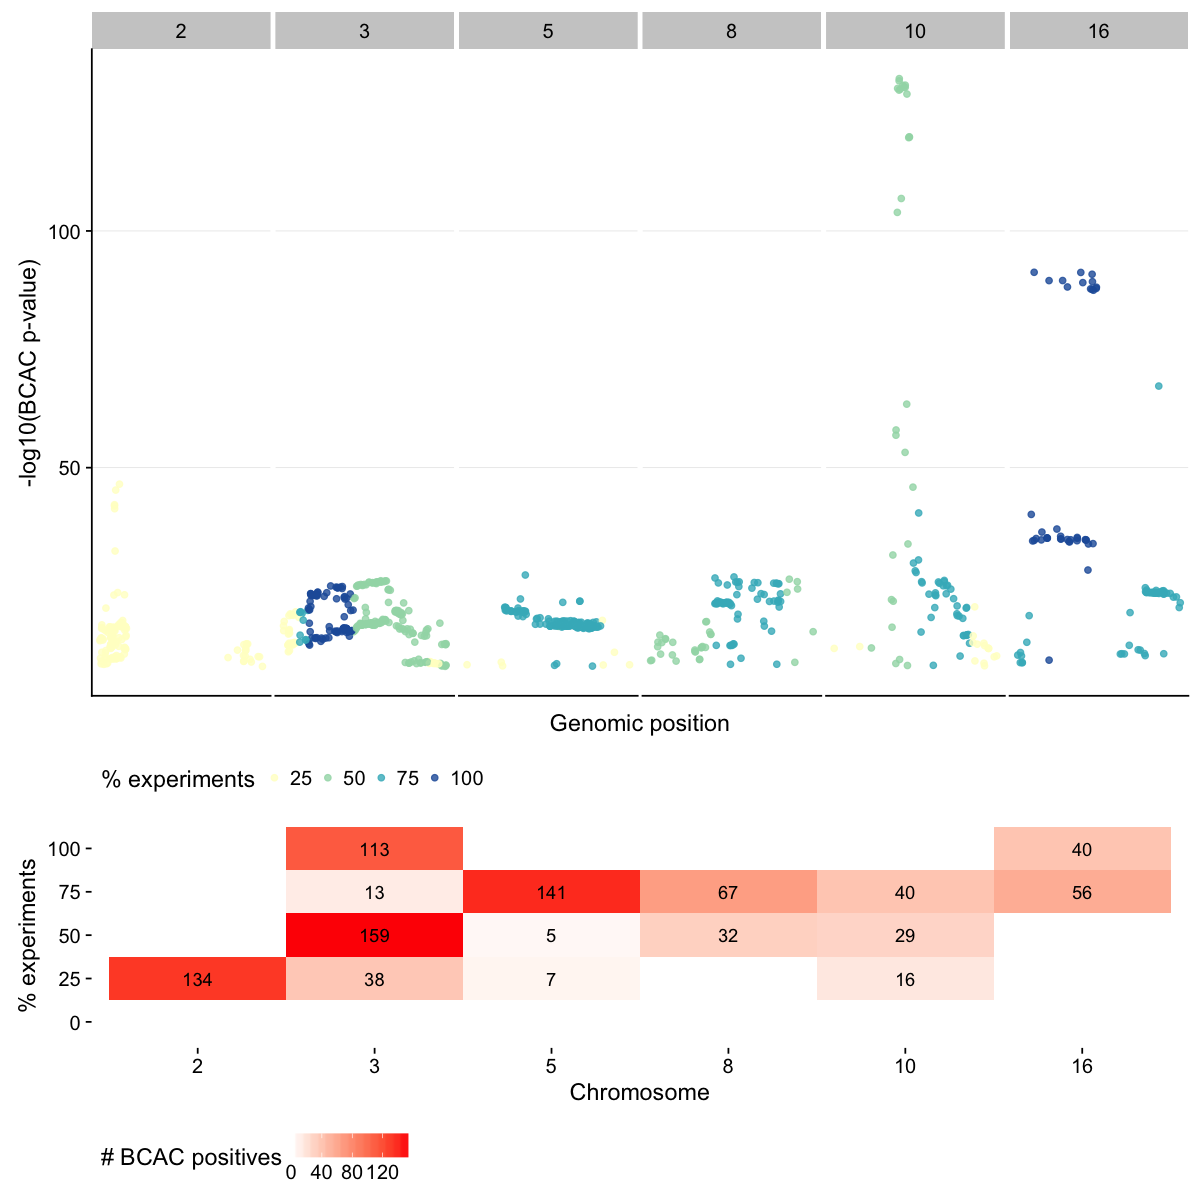

In [34]:
mh <- bcac %>%
    filter(p_bcac < 10^(-8)) %>%
    ggplot(aes(x = pos, y = -log10(p_bcac), color = consistency)) +
        geom_point(alpha = 0.8) +
        background_grid(major = "y", minor = "none") +
        theme(axis.text.x = element_blank(),
              axis.ticks.x = element_blank(),
              legend.position = "bottom",
              panel.spacing.x = unit(0.2, "lines")) +
        labs(x = "Genomic position", y = "-log10(BCAC p-value)", color = "% experiments") +
        scale_color_manual(values = c("0"="gray80", "25"="#ffffcc", 
                                      "50"="#a1dab4", "75"="#41b6c4", 
                                      "100"="#225ea8")) +
        facet_grid(. ~ chr, scales = "free_x")

ct <- bcac %>%
    filter(p_bcac < 10^(-8)) %>%
    select(consistency, chr) %>%
    table %>%
    as.data.frame %>%
    ggplot(aes(x = chr, y = consistency, fill = Freq)) +
        geom_tile() + 
        geom_text(aes(label = ifelse(Freq > 0, Freq, ""))) +
        labs(x = "Chromosome", y = "% experiments", fill = "# BCAC positives") +
        scale_fill_gradient(low = "white", high = "red")  +
        theme(legend.position = "bottom",
              axis.line = element_blank())

options(repr.plot.width=10, repr.plot.height=10)
plot_grid(mh, ct, nrow = 2, rel_heights = c(1, 0.48))

It looks like most of the SNPs in chromosomes 2, 3, 8 and 16 are detected. Around half of the ones in chromosomes 5 and 10. And we do quite bad in the rest, particularly in 6, 11 and 17, which hold a sizable amount of SNPs. Of course, the experimental conditions are not the same. It seems that BCAC also excluded BRCA1/2 carriers, as we can't find any mutation in their chromosomic regions.

# Pruned

The pruned dataset refers to GENESIS without SNPs in high LD i.e. SNPs with a R<sup>2</sup> >= 0.8. I analyzed this dataset in identical conditions as the previous i.e. χ<sup>2</sup> and consistency.

In [35]:
gs_pruned <- read_tsv("cones.evo.chi2.consistency.additive.gs.pruned.tsv", 
                      col_types = "ciiiccdld")
gm_pruned <- read_tsv("cones.evo.chi2.consistency.additive.gm.pruned.tsv", 
                      col_types = "ciiiccdld")
gi_pruned <- read_tsv("cones.evo.chi2.consistency.additive.gi.pruned.tsv", 
                      col_types = "ciiiccdld")

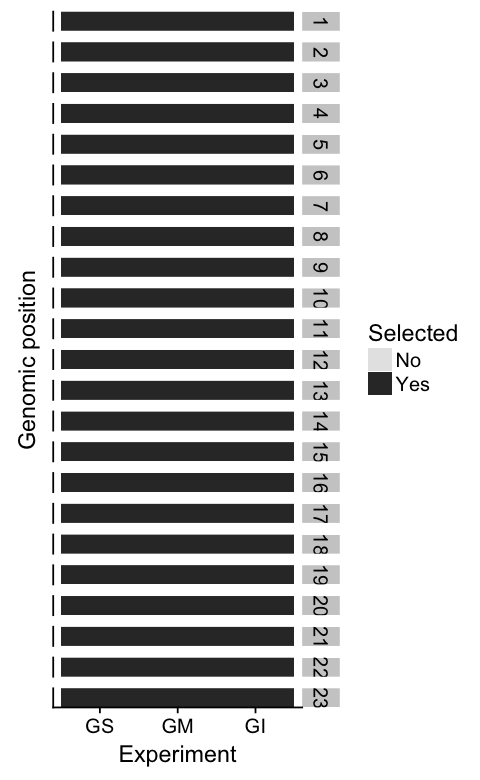

In [36]:
options(repr.plot.width=4, repr.plot.height=6.5)
consistency(GS = gs_pruned, GM = gm_pruned, GI = gi_pruned)

Surprisingly, the identified SNPs are (almost) the same between conditions.

[1] 2686

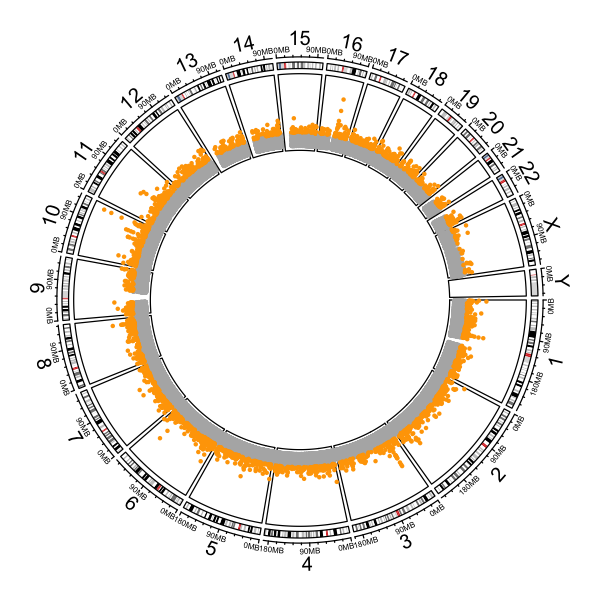

In [37]:
sum(gm_pruned$selected)
options(repr.plot.width=5, repr.plot.height=5)
plot_ideogram(gm_pruned)

It doesn't seem to be using the SNP network at all. An study of the hyperparameters would be necessary: maybe *consistency* is not the best criteria for this data.